<p><img alt="Colaboratory logo" height="300px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<center> <h1> <b>Verification of the theory of the 3-body problem with the JWST.</b> </h1>
<h2> Ana María López Aristiábal </h2>

<i>Physics Institute - Undergraduate Astronomy
<br> Celestial Mechanics
<br> Date: April 19, 2022
</i>
</center>

In [1]:
!wget https://github.com/seap-udea/MecanicaCeleste-Zuluaga/raw/master/pymcel.tgz &> /dev/null
!tar zxvf pymcel.tgz  &> /dev/null

In [2]:
!python -m pip install astroquery &> /dev/null
!python -m pip install spiceypy &> /dev/null

In [6]:
!pip install pymcel

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 662.1 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 394.1 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 541.8 kB/s eta 0:00:001m550.8 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 593.0 kB/s eta 0:00:00m585.1 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 837.9 kB/s eta 0:00:001m789.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 759.1 kB/s eta 0:00:001m702.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 534.2 kB/s eta 0:00:001m430.0 kB/s eta 0:00:01


In [7]:
#We import the libraries
import numpy as np
from pymcel.export import ncuerpos_solucion
from pymcel.export import plot_ncuerpos_3d
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from astroquery.jplhorizons import Horizons

Paquete pymcel cargado. Versión: 0.6.6


The first thing to do is to look up the date on which the James Webb Space Telescope reached its final orbit, since the starting point of our data interval depends on this date. After almost a month after its launch, the telescope reached its final orbit (i.e., L2) on January 24, 2022. So we will perform the data acquisition from this date until January 24, 2024 with a step of one day.

In [8]:
JWST = Horizons(id="JWST",location="@sun",epochs={"start":"2022-1-24","stop":"2024-1-24","step":"1d"}).vectors()

In [9]:
# Let's extract the positions and velocities
posx_JWST = JWST["x"].to("AU").value
posy_JWST = JWST["y"].to("AU").value
posz_JWST = JWST["z"].to("AU").value

We extract the data in astronomical units in a convenient way

Text(0.5, 0, 'z [AU]')

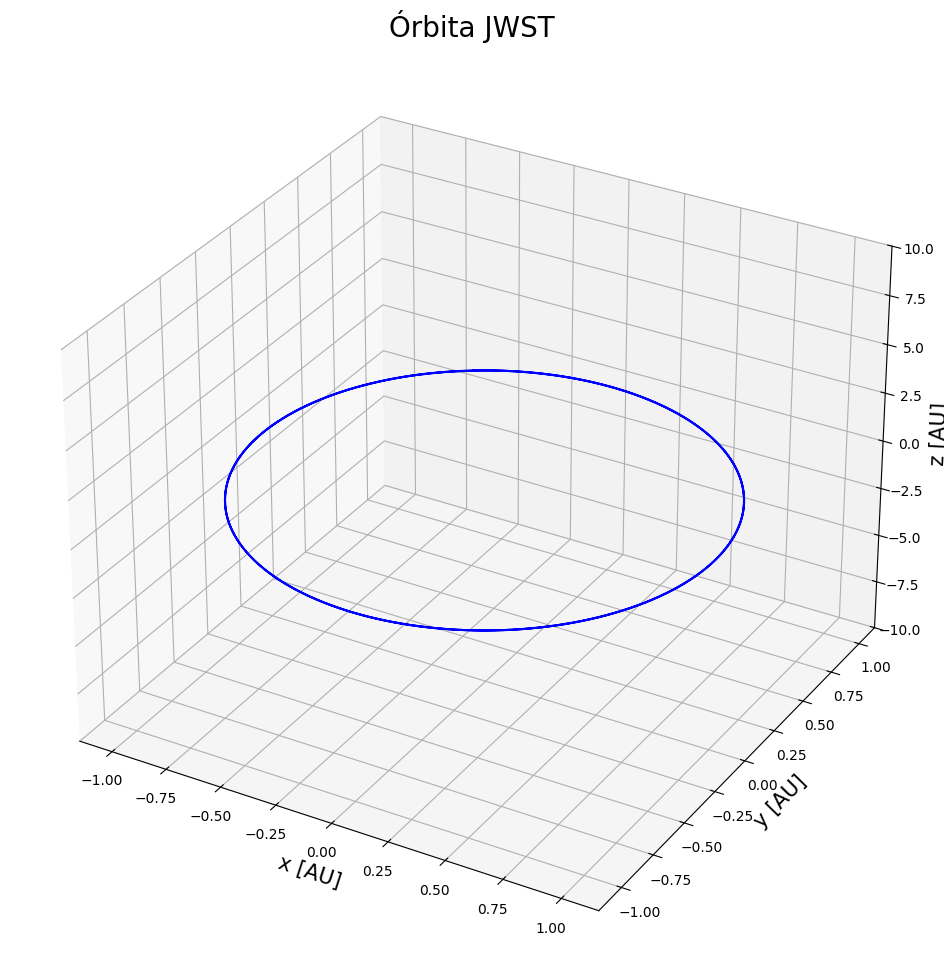

In [10]:
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot3D(posx_JWST, posy_JWST, posz_JWST, color='blue')
ax.set_zlim(-10,10)
ax.set_title('Órbita JWST',size=20)
ax.set_xlabel('x [AU]',size=15)
ax.set_ylabel('y [AU]',size=15)
ax.set_zlabel('z [AU]',size=15)


We extract the data in a similar way and for the same time interval but this time for the Earth:

In [11]:
Earth = Horizons(id="Earth-Moon Barycenter",location="@sun",epochs={"start":"2022-1-24","stop":"2024-1-24","step":"1d"}).vectors()
posx_Earth = Earth["x"].to("AU").value
posy_Earth = Earth["y"].to("AU").value
posz_Earth = Earth["z"].to("AU").value

Now, we are told that “the instantaneous angular velocity is equal to the component of the velocity of the Earth perpendicular to its distance, divided by the distance at that instant of time”, if we have two perpendicular legs we can construct a right triangle, from which we can calculate the variation in the angle of interest, that is, the instantaneous angular velocity. Since we know the value of the legs, which in this case would be the component in $y$ and the component in $x$ of the position of the Earth at each instant of time we calculate the $\omega(t)$ requested:

In [12]:
n = len(Earth)                    # Number of data extracted by taking day by day data for two years
omega = np.zeros(n)
for i in range(n):
  omega[i]=np.arctan2(posy_Earth[i],posx_Earth[i])

All the instantaneous angular velocities requested were stored in $\omega$. Now, we calculate the rotation matrix between the inertial reference frame and a rotating reference frame that accompanies the Earth in each of the time instants that we extracted the data. For this we use the routine built in class.

Text(0.5, 0, 'z')

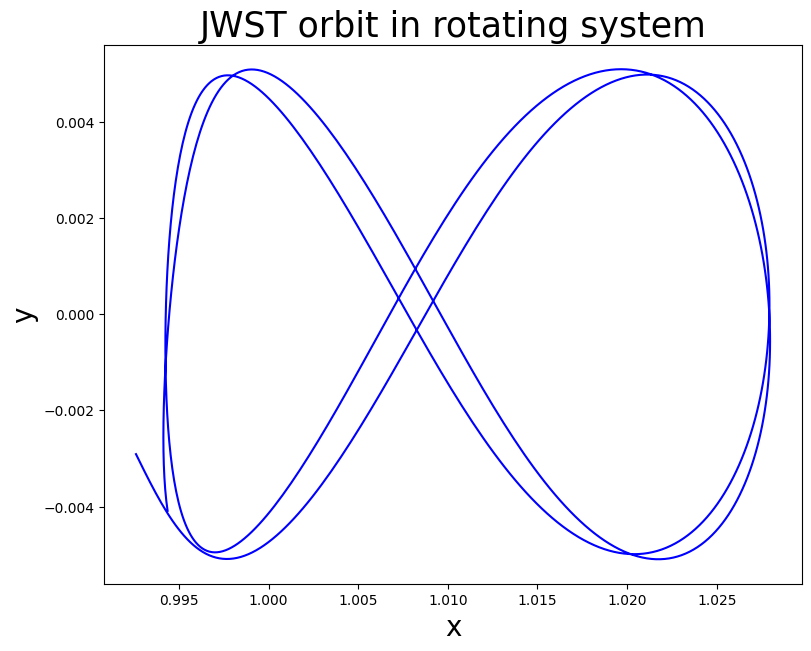

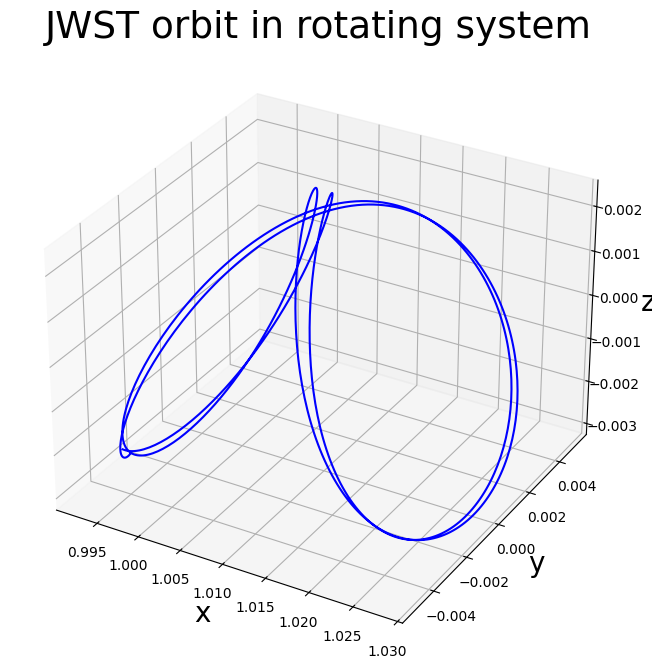

In [13]:
t = range(0,n)                            # We define an arrangement for the times

rot = []
rotx = []
roty = []
rotz = []
velrot = []
for i in range(0,n):
  # we define the position with its respective x, y and z coordinates
  position = np.array([posx_JWST[i],posy_JWST[i],posz_JWST[i]])

  # Rotation matrix
  from spiceypy import rotate
  # We rotate the calculated omega
  R = rotate(omega[i],3)

  # Rotation of position vector and velocity vector
  from spiceypy import mxv
  rs_rot_ = mxv(R,position)
  # We obtain the rotated vector
  rot.append(rs_rot_)

  # We separate the rotated vector we find in each of its components
  x = rot[i][0]
  rotx.append(x)
  y = rot[i][1]
  roty.append(y)
  z = rot[i][2]
  rotz.append(z)

  # Additionally we perform the calculation of the velocity that we will use for the calculation of Jacobi's constant
  v = np.linalg.norm((rot[i]-rot[i-1])/(t[i]-t[i-1])) # We perform the calculation numerically
  velrot.append(v) # We store the data obtained

plt.figure(figsize=(9,7))
plt.plot(rotx,roty,color="blue")
plt.title("JWST orbit in rotating system",size=25)
plt.xlabel("x",size=20)
plt.ylabel("y",size=20)

fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.plot3D(rotx,roty, rotz, color='blue')
ax.set_title('JWST orbit in rotating system',size=27)
ax.set_xlabel('x',size=20)
ax.set_ylabel('y',size=20)
ax.set_zlabel('z',size=20)

By adjusting the axes of the graph shown above we arrive at the following graph.

Text(0, 0.5, 'y')

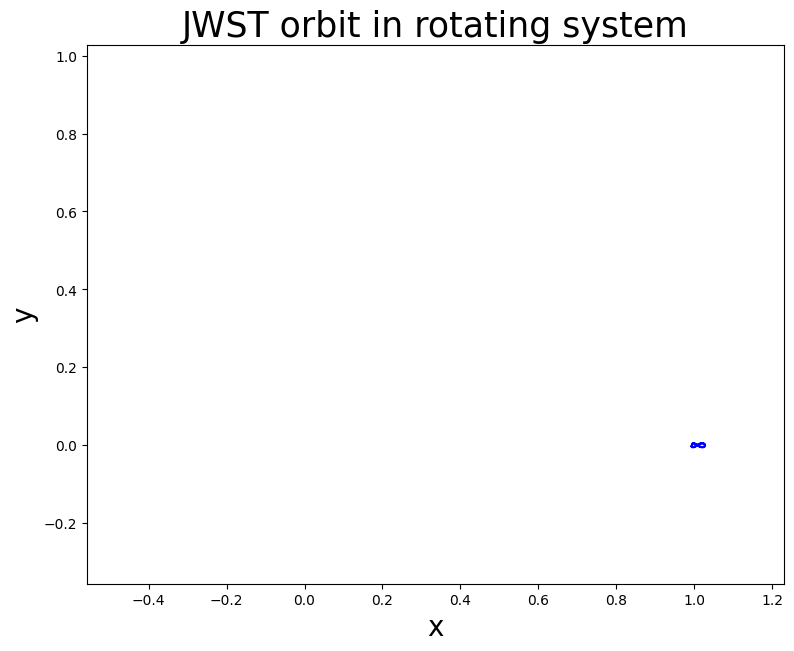

In [14]:
from pymcel.plot import fija_ejes_proporcionales
fig = plt.figure(figsize=(9,7))
ax = fig.gca()
ax.plot(rotx,roty,color="blue")
fija_ejes_proporcionales(ax,rot)
plt.title("JWST orbit in rotating system",size=25)
plt.xlabel("x",size=20)
plt.ylabel("y",size=20)

This is to be expected since the JWTS is at an equipotential equilibrium point, which seen from the rotating system is a fixed point in space.

Now, we perform the calculation of the Jacobi constant for each of the extracted time instants using the routine shown in the text guide.

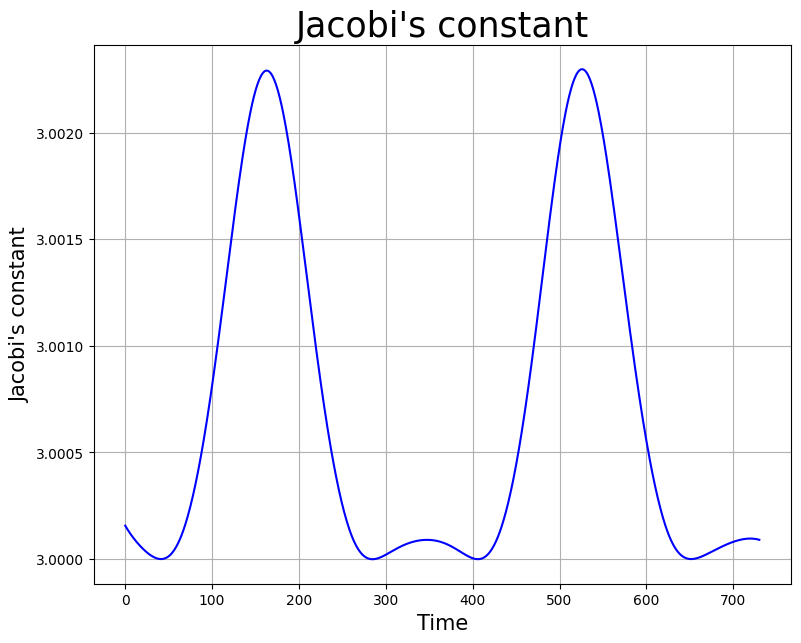

In [15]:
m = 6200                            # telescope mass [kg]
M = 5.97e24                         # Earth's mass [kg]
alpha = m/(m+M)

def jacobi_constant(alfa,r,vel):
    from numpy import array
    r=array(r)
    vel=array(vel)
    
    x=r[:,0]
    y=r[:,1]
    z=r[:,2]

    # Relative positions
    from numpy import sqrt
    r1=sqrt((x+alfa)**2+y**2+z**2)
    r2=sqrt((x-1+alfa)**2+y**2+z**2)

    # Constant value
    CJ=2*(1-alfa)/r1+2*alfa/r2+(x**2+y**2)-vel**2
    return CJ

CJ = jacobi_constant(alpha,rot,velrot)
plt.figure(figsize=(9,7))
plt.plot(t,CJ,color="blue")
plt.title("Jacobi's constant",size=25)
plt.xlabel("Time",size=15)
plt.ylabel("Jacobi's constant",size=15)
plt.grid()

In [16]:
(max(CJ)-min(CJ))   # Maximum difference of the values found for the Jacobi constant

np.float64(0.0022977680261004885)

Note that the variations in the value of the constant are very insignificant, so we could say that it effectively behaves as a “cosntant”, in addition, values very close to three were obtained, which is the expected value for an object that is highly perturbed by the Earth as is the case of the JWST.